In [1]:
# !pip install diffusers
# !pip install --upgrade huggingface-hub
# !pip install --upgrade botocore
# !pip install datasets
# !pip install accelerate


In [2]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.optim import AdamW
from diffusers import UNet2DModel, DDPMScheduler, DDPMPipeline
from diffusers.optimization import get_cosine_schedule_with_warmup
from datasets import load_dataset
from accelerate import Accelerator
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import random 
import timeit

/home/farshid/anaconda3/envs/pytorch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
RANDOM_SEED = 42
IMG_SIZE = 128
BATCH_SIZE = 3
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50
NUM_GENERATE_IMAGES = 9
NUM_TIMESTEPS = 1000
MIXED_PRECISION = "fp16"
GRADIENT_ACCUMULATION_STEPS = 1

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

/home/farshid/anaconda3/envs/pytorch/lib/python3.8/site-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


/tmp/ipykernel_161453/2340717843.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


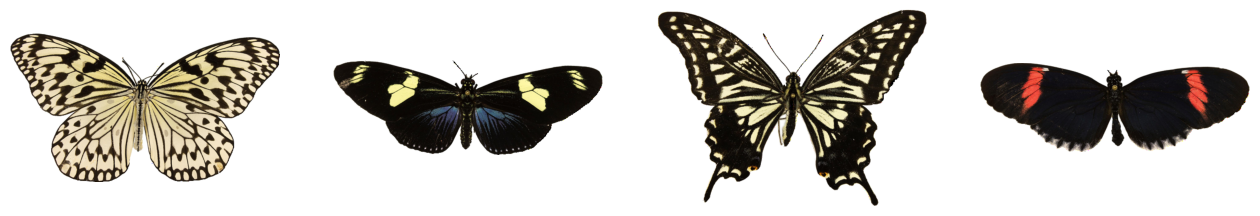

In [5]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

In [6]:
preprocess = transforms.Compose(
[
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [7]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

In [8]:
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
model = UNet2DModel(
    sample_size=IMG_SIZE,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(128, 128, 256, 256, 512, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D"
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
    )
)
model = model.to(device)
model

UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): LoRACompatibleLinear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): LoRACompatibleLinear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0): ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
          (conv1): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): LoRACompatibleLinear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
        (1): ResnetBlock2D(
        

In [10]:
sample_image = dataset[0]["images"].unsqueeze(0).to(device)
print("Input shape", sample_image.shape)
print("Output shape", model(sample_image, timestep=0).sample.shape)

Input shape torch.Size([1, 3, 128, 128])
Output shape torch.Size([1, 3, 128, 128])


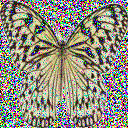

In [11]:
noise_scheduler = DDPMScheduler(num_train_timesteps=NUM_TIMESTEPS)
noise = torch.randn(sample_image.shape).to(device)
timesteps = torch.LongTensor([50]).to(device)
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).cpu().numpy()[0])

In [12]:
noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)
print(loss)

tensor(1.1955, device='cuda:0', grad_fn=<MseLossBackward0>)


In [13]:
def sample_image_generation(model, noise_scheduler, num_generate_images, random_seed, num_timesteps):
    pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
    
    images = pipeline(
        batch_size=num_generate_images,
        generator=torch.manual_seed(random_seed),
        num_inference_steps=num_timesteps
    ).images
    
    fig = plt.figure()
    for i in range(1, num_generate_images+1):
        fig.add_subplot(3, 3, i)
        plt.imshow(images[i-1])
    plt.show()

100%|██████████| 334/334 [01:17<00:00,  4.33it/s]


------------------------------
Train Loss EPOCH: 1: 0.2484
Train Learning Rate EPOCH: 1: 6.680000000000001e-05


100%|██████████| 1000/1000 [02:36<00:00,  6.38it/s]


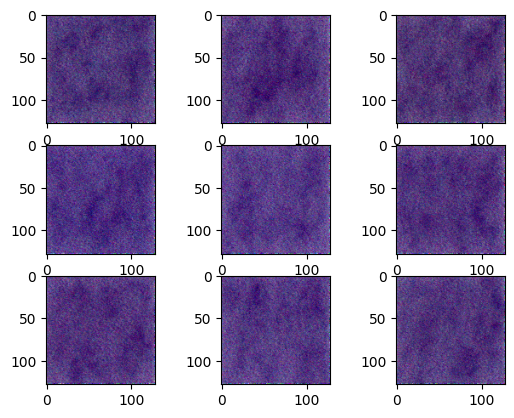

  2%|▏         | 1/50 [03:54<3:11:26, 234.42s/it]

------------------------------


  4%|▍         | 2/50 [05:12<1:53:44, 142.19s/it]

------------------------------
Train Loss EPOCH: 2: 0.0443
Train Learning Rate EPOCH: 2: 9.997346678513569e-05
------------------------------


  6%|▌         | 3/50 [06:29<1:28:11, 112.57s/it]

------------------------------
Train Loss EPOCH: 3: 0.0309
Train Learning Rate EPOCH: 3: 9.976325863727746e-05
------------------------------


  8%|▊         | 4/50 [07:46<1:15:41, 98.74s/it] 

------------------------------
Train Loss EPOCH: 4: 0.0236
Train Learning Rate EPOCH: 4: 9.934435184737909e-05
------------------------------


 10%|█         | 5/50 [09:04<1:08:15, 91.02s/it]

------------------------------
Train Loss EPOCH: 5: 0.0241
Train Learning Rate EPOCH: 5: 9.871850323926177e-05
------------------------------


 12%|█▏        | 6/50 [10:21<1:03:21, 86.39s/it]

------------------------------
Train Loss EPOCH: 6: 0.0243
Train Learning Rate EPOCH: 6: 9.788833751553165e-05
------------------------------


 14%|█▍        | 7/50 [11:39<59:49, 83.47s/it]  

------------------------------
Train Loss EPOCH: 7: 0.0253
Train Learning Rate EPOCH: 7: 9.685733625002363e-05
------------------------------


 16%|█▌        | 8/50 [12:56<57:06, 81.58s/it]

------------------------------
Train Loss EPOCH: 8: 0.0239
Train Learning Rate EPOCH: 8: 9.562982328667289e-05
------------------------------


 18%|█▊        | 9/50 [14:14<54:50, 80.26s/it]

------------------------------
Train Loss EPOCH: 9: 0.0196
Train Learning Rate EPOCH: 9: 9.42109466060489e-05
------------------------------


 20%|██        | 10/50 [15:31<52:51, 79.28s/it]

------------------------------
Train Loss EPOCH: 10: 0.0172
Train Learning Rate EPOCH: 10: 9.260665673560057e-05
------------------------------


100%|██████████| 334/334 [01:16<00:00,  4.36it/s]


------------------------------
Train Loss EPOCH: 11: 0.0173
Train Learning Rate EPOCH: 11: 9.082368179415632e-05


100%|██████████| 1000/1000 [02:35<00:00,  6.42it/s]


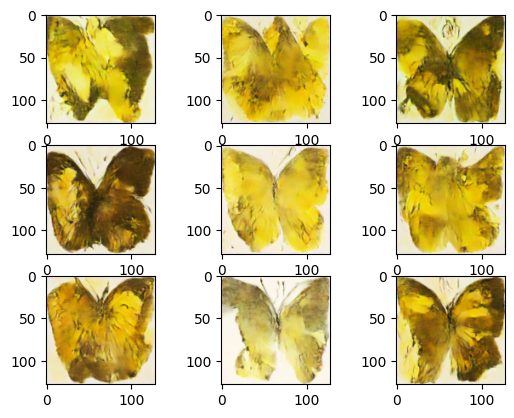

 22%|██▏       | 11/50 [19:24<1:22:07, 126.35s/it]

------------------------------


 24%|██▍       | 12/50 [20:41<1:10:35, 111.47s/it]

------------------------------
Train Loss EPOCH: 12: 0.0177
Train Learning Rate EPOCH: 12: 8.886949927533817e-05
------------------------------


 26%|██▌       | 13/50 [21:59<1:02:26, 101.26s/it]

------------------------------
Train Loss EPOCH: 13: 0.0185
Train Learning Rate EPOCH: 13: 8.67523046882254e-05
------------------------------


 28%|██▊       | 14/50 [23:17<56:31, 94.21s/it]   

------------------------------
Train Loss EPOCH: 14: 0.0156
Train Learning Rate EPOCH: 14: 8.44809771867835e-05
------------------------------


 30%|███       | 15/50 [24:35<52:05, 89.29s/it]

------------------------------
Train Loss EPOCH: 15: 0.0182
Train Learning Rate EPOCH: 15: 8.206504233220277e-05
------------------------------


 32%|███▏      | 16/50 [25:53<48:39, 85.87s/it]

------------------------------
Train Loss EPOCH: 16: 0.0188
Train Learning Rate EPOCH: 16: 7.951463214431507e-05
------------------------------


 34%|███▍      | 17/50 [27:10<45:52, 83.42s/it]

------------------------------
Train Loss EPOCH: 17: 0.0203
Train Learning Rate EPOCH: 17: 7.684044260962593e-05
------------------------------


 36%|███▌      | 18/50 [28:28<43:33, 81.66s/it]

------------------------------
Train Loss EPOCH: 18: 0.0197
Train Learning Rate EPOCH: 18: 7.405368882416668e-05
------------------------------


 38%|███▊      | 19/50 [29:45<41:33, 80.44s/it]

------------------------------
Train Loss EPOCH: 19: 0.0163
Train Learning Rate EPOCH: 19: 7.116605795928924e-05
------------------------------


 40%|████      | 20/50 [31:03<39:47, 79.59s/it]

------------------------------
Train Loss EPOCH: 20: 0.0144
Train Learning Rate EPOCH: 20: 6.818966024765758e-05
------------------------------


100%|██████████| 334/334 [01:17<00:00,  4.31it/s]


------------------------------
Train Loss EPOCH: 21: 0.0150
Train Learning Rate EPOCH: 21: 6.513697819499174e-05


100%|██████████| 1000/1000 [02:37<00:00,  6.37it/s]


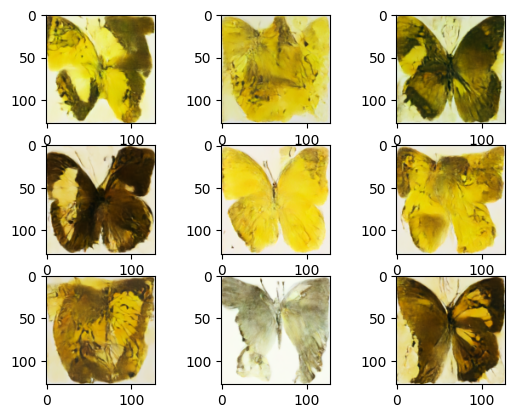

 42%|████▏     | 21/50 [34:58<1:01:01, 126.26s/it]

------------------------------


 44%|████▍     | 22/50 [36:15<52:02, 111.51s/it]  

------------------------------
Train Loss EPOCH: 22: 0.0154
Train Learning Rate EPOCH: 22: 6.202081423056221e-05
------------------------------


 46%|████▌     | 23/50 [37:32<45:29, 101.10s/it]

------------------------------
Train Loss EPOCH: 23: 0.0157
Train Learning Rate EPOCH: 23: 5.885423701597917e-05
------------------------------


 48%|████▊     | 24/50 [38:49<40:39, 93.82s/it] 

------------------------------
Train Loss EPOCH: 24: 0.0138
Train Learning Rate EPOCH: 24: 5.5650526637448695e-05
------------------------------


 50%|█████     | 25/50 [40:06<36:59, 88.78s/it]

------------------------------
Train Loss EPOCH: 25: 0.0157
Train Learning Rate EPOCH: 25: 5.242311891135016e-05
------------------------------


 52%|█████▏    | 26/50 [41:23<34:07, 85.31s/it]

------------------------------
Train Loss EPOCH: 26: 0.0166
Train Learning Rate EPOCH: 26: 4.918554903670771e-05
------------------------------


 54%|█████▍    | 27/50 [42:41<31:50, 83.05s/it]

------------------------------
Train Loss EPOCH: 27: 0.0178
Train Learning Rate EPOCH: 27: 4.5951394830867966e-05
------------------------------


 56%|█████▌    | 28/50 [43:59<29:50, 81.40s/it]

------------------------------
Train Loss EPOCH: 28: 0.0174
Train Learning Rate EPOCH: 28: 4.2734219786443515e-05
------------------------------


 58%|█████▊    | 29/50 [45:20<28:29, 81.42s/it]

------------------------------
Train Loss EPOCH: 29: 0.0146
Train Learning Rate EPOCH: 29: 3.9547516188332196e-05
------------------------------


 60%|██████    | 30/50 [46:40<27:02, 81.13s/it]

------------------------------
Train Loss EPOCH: 30: 0.0130
Train Learning Rate EPOCH: 30: 3.640464852936909e-05
------------------------------


100%|██████████| 334/334 [01:16<00:00,  4.36it/s]


------------------------------
Train Loss EPOCH: 31: 0.0137
Train Learning Rate EPOCH: 31: 3.3318797461917026e-05


100%|██████████| 1000/1000 [02:31<00:00,  6.58it/s]


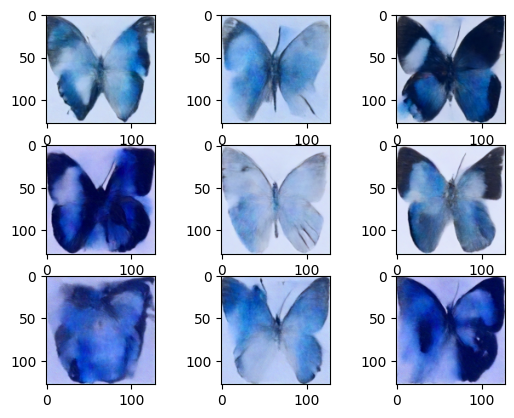

 62%|██████▏   | 31/50 [50:30<39:45, 125.53s/it]

------------------------------


 64%|██████▍   | 32/50 [51:45<33:07, 110.42s/it]

------------------------------
Train Loss EPOCH: 32: 0.0139
Train Learning Rate EPOCH: 32: 3.0302904520452447e-05
------------------------------


 66%|██████▌   | 33/50 [53:00<28:17, 99.88s/it] 

------------------------------
Train Loss EPOCH: 33: 0.0141
Train Learning Rate EPOCH: 33: 2.736961784697122e-05
------------------------------


 68%|██████▊   | 34/50 [54:16<24:44, 92.79s/it]

------------------------------
Train Loss EPOCH: 34: 0.0125
Train Learning Rate EPOCH: 34: 2.4531239146832592e-05
------------------------------


 70%|███████   | 35/50 [55:32<21:53, 87.54s/it]

------------------------------
Train Loss EPOCH: 35: 0.0142
Train Learning Rate EPOCH: 35: 2.179967209749929e-05
------------------------------


 72%|███████▏  | 36/50 [56:50<19:47, 84.85s/it]

------------------------------
Train Loss EPOCH: 36: 0.0151
Train Learning Rate EPOCH: 36: 1.918637242653919e-05
------------------------------


 74%|███████▍  | 37/50 [58:28<19:13, 88.71s/it]

------------------------------
Train Loss EPOCH: 37: 0.0159
Train Learning Rate EPOCH: 37: 1.670953384468754e-05
------------------------------


 76%|███████▌  | 38/50 [59:43<16:54, 84.56s/it]

------------------------------
Train Loss EPOCH: 38: 0.0159
Train Learning Rate EPOCH: 38: 1.436467310091727e-05
------------------------------


 78%|███████▊  | 39/50 [1:00:58<14:58, 81.64s/it]

------------------------------
Train Loss EPOCH: 39: 0.0135
Train Learning Rate EPOCH: 39: 1.216926085662536e-05
------------------------------


 80%|████████  | 40/50 [1:02:13<13:16, 79.65s/it]

------------------------------
Train Loss EPOCH: 40: 0.0121
Train Learning Rate EPOCH: 40: 1.0132504297326778e-05
------------------------------


100%|██████████| 334/334 [01:17<00:00,  4.31it/s]


------------------------------
Train Loss EPOCH: 41: 0.0128
Train Learning Rate EPOCH: 41: 8.262945233580765e-06


100%|██████████| 1000/1000 [02:35<00:00,  6.44it/s]


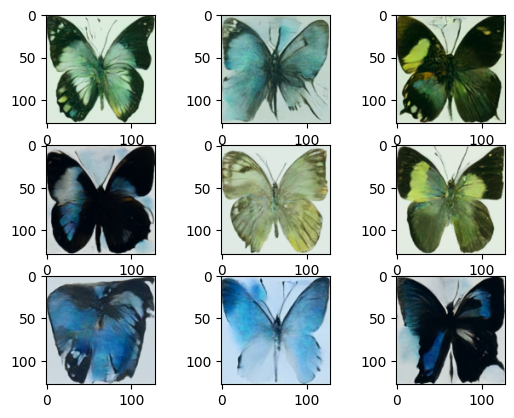

 82%|████████▏ | 41/50 [1:06:06<18:52, 125.79s/it]

------------------------------


 84%|████████▍ | 42/50 [1:07:23<14:49, 111.19s/it]

------------------------------
Train Loss EPOCH: 42: 0.0130
Train Learning Rate EPOCH: 42: 6.568424278090446e-06
------------------------------


 86%|████████▌ | 43/50 [1:08:40<11:46, 100.89s/it]

------------------------------
Train Loss EPOCH: 43: 0.0131
Train Learning Rate EPOCH: 43: 5.060297685041659e-06
------------------------------


 88%|████████▊ | 44/50 [1:09:57<09:22, 93.70s/it] 

------------------------------
Train Loss EPOCH: 44: 0.0118
Train Learning Rate EPOCH: 44: 3.7358356398446427e-06
------------------------------


 90%|█████████ | 45/50 [1:11:14<07:23, 88.71s/it]

------------------------------
Train Loss EPOCH: 45: 0.0133
Train Learning Rate EPOCH: 45: 2.6053976304822368e-06
------------------------------


 92%|█████████▏| 46/50 [1:12:31<05:41, 85.26s/it]

------------------------------
Train Loss EPOCH: 46: 0.0143
Train Learning Rate EPOCH: 46: 1.6737245216792375e-06
------------------------------


 94%|█████████▍| 47/50 [1:13:49<04:08, 82.94s/it]

------------------------------
Train Loss EPOCH: 47: 0.0150
Train Learning Rate EPOCH: 47: 9.447235919772202e-07
------------------------------


 96%|█████████▌| 48/50 [1:15:06<02:42, 81.27s/it]

------------------------------
Train Loss EPOCH: 48: 0.0151
Train Learning Rate EPOCH: 48: 4.2145214727298264e-07
------------------------------


 98%|█████████▊| 49/50 [1:16:24<01:20, 80.20s/it]

------------------------------
Train Loss EPOCH: 49: 0.0130
Train Learning Rate EPOCH: 49: 1.061046989976e-07
------------------------------


100%|██████████| 50/50 [1:17:42<00:00, 93.25s/it]

------------------------------
Train Loss EPOCH: 50: 0.0117
Train Learning Rate EPOCH: 50: 3.760708838784765e-12
------------------------------
Training Time: 4662.27s


In [14]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(train_dataloader)*NUM_EPOCHS
)

accelerator = Accelerator(
    mixed_precision=MIXED_PRECISION,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS
)

model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(model, optimizer, train_dataloader, lr_scheduler)

start = timeit.default_timer()
for epoch in tqdm(range(NUM_EPOCHS), position=0, leave=True):
    model.train()
    train_running_loss = 0
    for idx, batch in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        clean_images = batch["images"].to(device)
        noise = torch.randn(clean_images.shape).to(device)
        last_batch_size = len(clean_images)
        
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (last_batch_size,)).to(device)
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
        
        with accelerator.accumulate(model):
            noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
            loss = F.mse_loss(noise_pred, noise)
            accelerator.backward(loss)
            
            accelerator.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            
        train_running_loss += loss.item()
    train_loss = train_running_loss / (idx+1)
    
    train_learning_rate = lr_scheduler.get_last_lr()[0]
    print("-"*30)
    print(f"Train Loss EPOCH: {epoch+1}: {train_loss:.4f}")
    print(f"Train Learning Rate EPOCH: {epoch+1}: {train_learning_rate}")
    if epoch%10 == 0:
        sample_image_generation(model, noise_scheduler, NUM_GENERATE_IMAGES, RANDOM_SEED, NUM_TIMESTEPS)
    print("-"*30)
    
stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 21.50it/s]


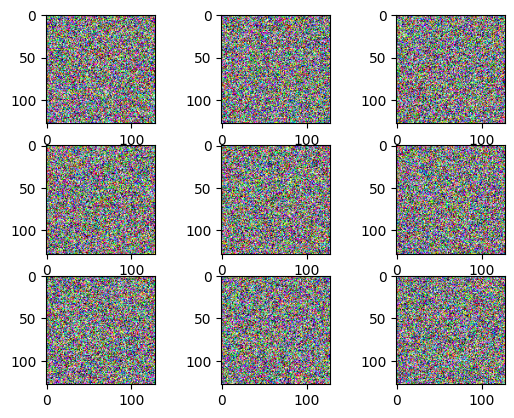

100%|██████████| 2/2 [00:00<00:00, 10.22it/s]


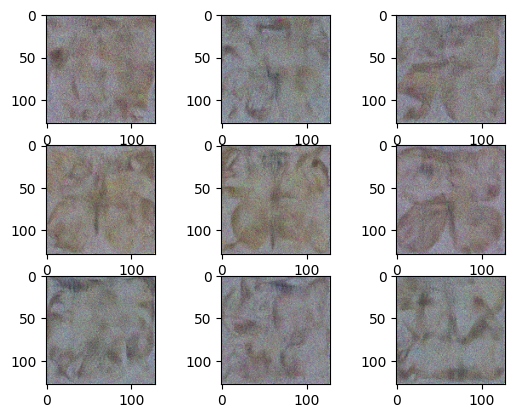

100%|██████████| 3/3 [00:00<00:00,  8.50it/s]


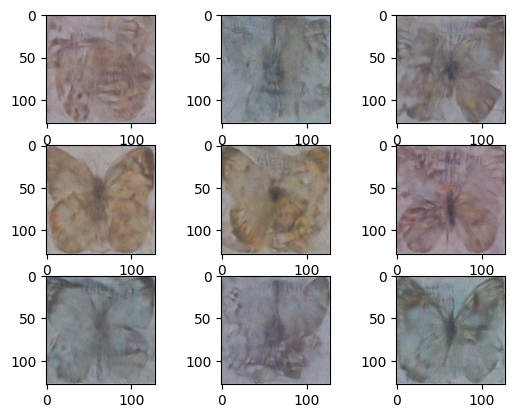

100%|██████████| 4/4 [00:00<00:00,  7.90it/s]


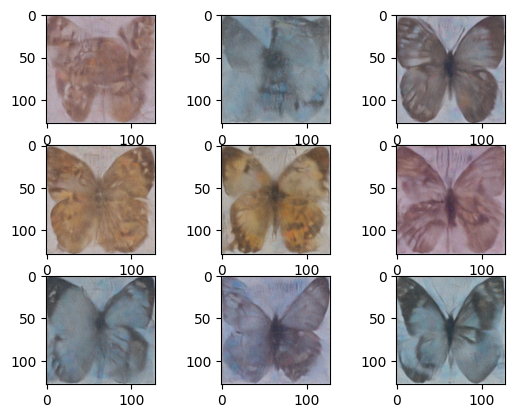

100%|██████████| 5/5 [00:00<00:00,  7.60it/s]


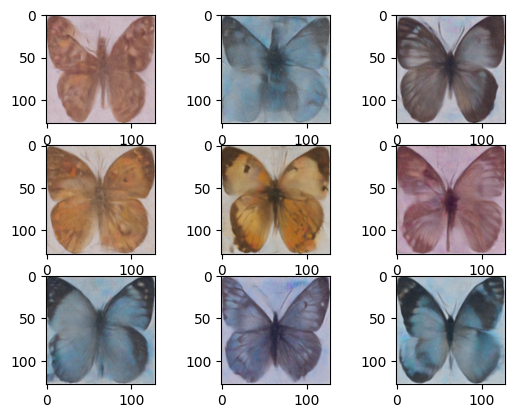

100%|██████████| 10/10 [00:01<00:00,  7.02it/s]


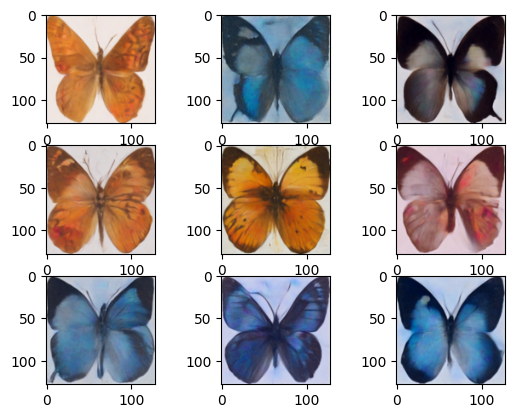

100%|██████████| 100/100 [00:15<00:00,  6.52it/s]


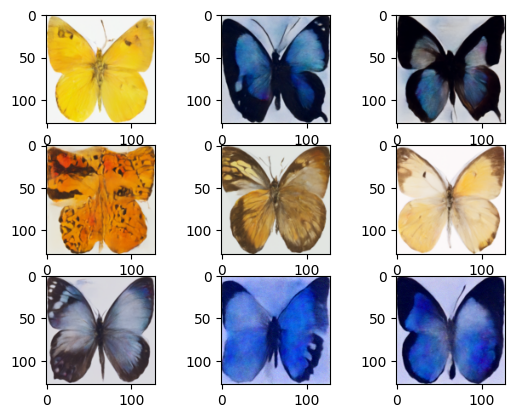

100%|██████████| 1000/1000 [02:35<00:00,  6.42it/s]


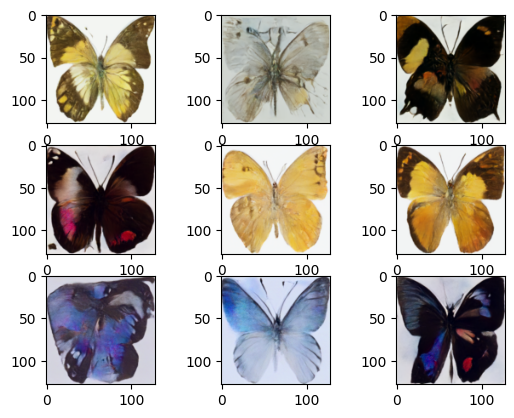

In [20]:
for i in [1, 2,3,4,5,10,100,1000]:

    sample_image_generation(model, noise_scheduler, NUM_GENERATE_IMAGES, RANDOM_SEED, i)